In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import json

sns.set()

%config InlineBackend.figure_format = 'svg'

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["image.cmap"] = "viridis"
import pandas as pd

In [3]:
def load_json(name):
    with open(f"../data/json/{name}.json", "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

In [4]:
json_data = load_json("data")

df = pd.DataFrame(json_data)

df.head()

,id,player_id,game_id,role,is_new,is_new_role,division,team_avg_sr,opponent_avg_sr,target
0,1,1,1,tank,True,True,11,800,714,False
1,2,2,1,tank,True,True,17,800,714,False
2,3,3,1,dps,True,True,11,800,714,False
3,4,4,1,dps,True,True,17,800,714,False
4,5,5,1,support,True,True,7,800,714,False


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43121 entries, 0 to 43120
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               43121 non-null  int64 
 1   player_id        43121 non-null  int64 
 2   game_id          43121 non-null  int64 
 3   role             42776 non-null  object
 4   is_new           43121 non-null  bool  
 5   is_new_role      43121 non-null  bool  
 6   division         43121 non-null  object
 7   team_avg_sr      43121 non-null  object
 8   opponent_avg_sr  43121 non-null  object
 9   target           43121 non-null  bool  
dtypes: bool(3), int64(3), object(4)
memory usage: 2.4+ MB


In [6]:
df["division"] = df["division"].astype("int64")
df["team_avg_sr"] = df["team_avg_sr"].astype("float64")
df["opponent_avg_sr"] = df["opponent_avg_sr"].astype("float64")
df["role"] = df["role"].apply(lambda x: 1 if x == "tank" else (2 if x == "dps" else 3)).astype("int64")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43121 entries, 0 to 43120
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               43121 non-null  int64  
 1   player_id        43121 non-null  int64  
 2   game_id          43121 non-null  int64  
 3   role             43121 non-null  int64  
 4   is_new           43121 non-null  bool   
 5   is_new_role      43121 non-null  bool   
 6   division         43121 non-null  int64  
 7   team_avg_sr      43121 non-null  float64
 8   opponent_avg_sr  43121 non-null  float64
 9   target           43121 non-null  bool   
dtypes: bool(3), float64(2), int64(5)
memory usage: 2.4 MB


In [7]:
df['cum_wins'] = df.groupby('player_id')['target'].cumsum()
df['cum_matches'] = df.groupby('player_id').cumcount() + 1

df['win_rate'] = df['cum_wins'] / df['cum_matches']

df['win_rate'] = df['win_rate'].fillna(0)

df.head()

,id,player_id,game_id,role,is_new,is_new_role,division,team_avg_sr,opponent_avg_sr,target,cum_wins,cum_matches,win_rate
0,1,1,1,1,True,True,11,800.0,714.0,False,0,1,0.0
1,2,2,1,1,True,True,17,800.0,714.0,False,0,1,0.0
2,3,3,1,2,True,True,11,800.0,714.0,False,0,1,0.0
3,4,4,1,2,True,True,17,800.0,714.0,False,0,1,0.0
4,5,5,1,3,True,True,7,800.0,714.0,False,0,1,0.0


In [8]:
from collections import defaultdict
from itertools import combinations

global_team_chemistry = defaultdict(lambda: defaultdict(int))

df['team_chemistry'] = 0
df['opponent_chemistry'] = 0

for game_id, match_data in df.groupby('game_id'):
    winners = match_data[match_data['target']]['player_id'].tolist()
    losers = match_data[~match_data['target']]['player_id'].tolist()
    
    for idx, row in match_data.iterrows():
        player_id = row['player_id']
        is_winner = row['target']
        
        my_team = winners if is_winner else losers
        opponent_team = losers if is_winner else winners
        
        team_chemistry = 0
        for p1, p2 in combinations(my_team, 2):
            team_chemistry += global_team_chemistry[p1].get(p2, 0)
        df.at[idx, 'team_chemistry'] = team_chemistry
        
        opponent_chemistry = 0
        for p1, p2 in combinations(opponent_team, 2):
            opponent_chemistry += global_team_chemistry[p1].get(p2, 0)
        df.at[idx, 'opponent_chemistry'] = opponent_chemistry

    for p1, p2 in combinations(winners, 2):
        global_team_chemistry[p1][p2] += 1
        global_team_chemistry[p2][p1] += 1
    
    for p1, p2 in combinations(losers, 2):
        global_team_chemistry[p1][p2] += 1
        global_team_chemistry[p2][p1] += 1

df['team_chemistry'] = df['team_chemistry'].fillna(0)
df['opponent_chemistry'] = df['opponent_chemistry'].fillna(0)


In [9]:
df.tail()

,id,player_id,game_id,role,is_new,is_new_role,division,team_avg_sr,opponent_avg_sr,target,cum_wins,cum_matches,win_rate,team_chemistry,opponent_chemistry
43116,43117,1224,4081,1,True,True,17,860.0,900.0,False,7,10,0.700000,91,102
43117,43118,823,4081,2,False,False,7,860.0,900.0,False,49,134,0.365672,91,102
43118,43119,831,4081,2,False,False,13,860.0,900.0,False,18,37,0.486486,91,102
43119,43120,1194,4081,3,False,False,10,860.0,900.0,False,8,15,0.533333,91,102
43120,43121,1089,4081,3,False,False,15,860.0,900.0,False,45,103,0.436893,91,102


In [10]:
df["win_rate"].mean()

np.float64(0.4341326157785087)

<Axes: xlabel='division'>

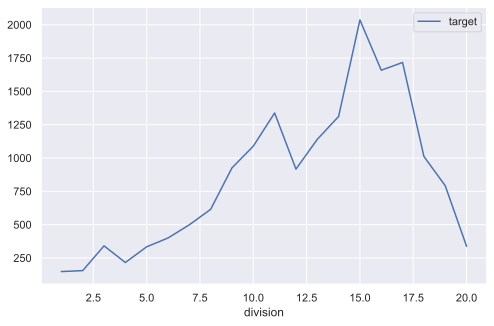

In [11]:
df[["target", "division"]].groupby(
    "division"
).sum().plot()

<Axes: xlabel='division', ylabel='Density'>

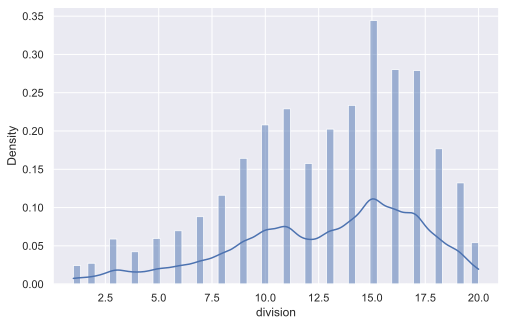

In [12]:
sns.histplot(df["division"], kde=True, stat = "density")

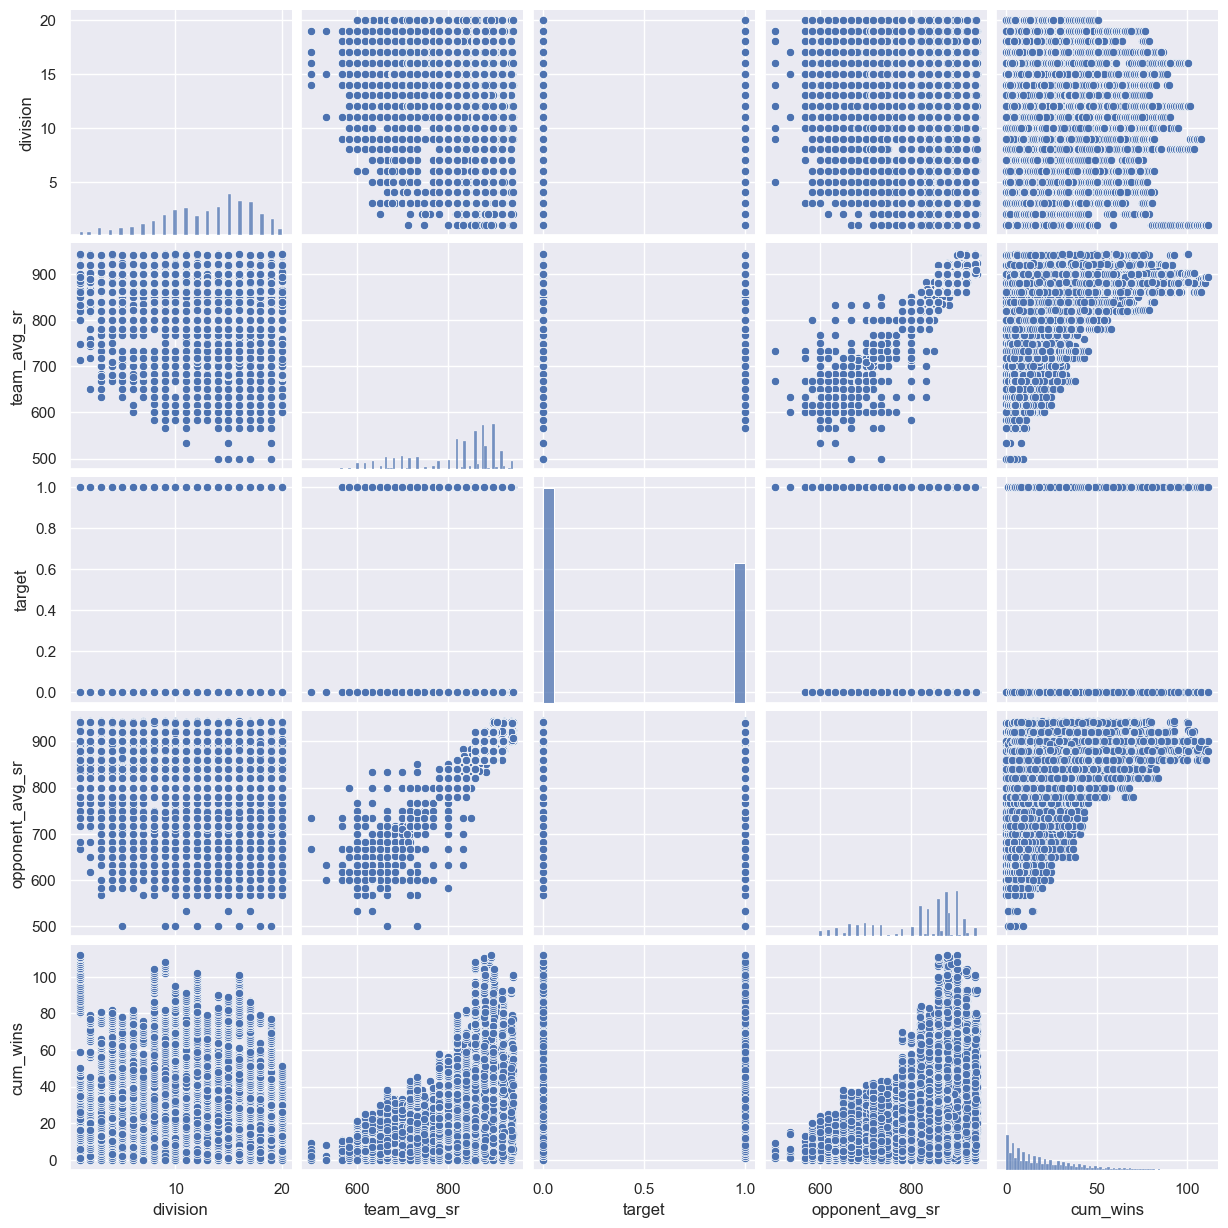

In [13]:
%config InlineBackend.figure_format = 'png'
sns.pairplot(
    df[["division", "team_avg_sr", "target", "opponent_avg_sr", "cum_wins"]]
);

<Axes: title={'center': 'Распределение по ролям'}, ylabel='count'>

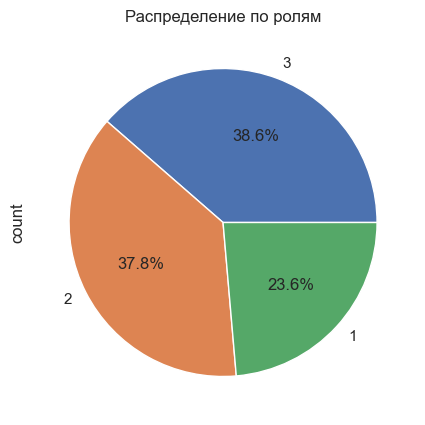

In [14]:
df['role'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Распределение по ролям')

<Axes: title={'center': 'Сыгранность команд по матчам'}, xlabel='id'>

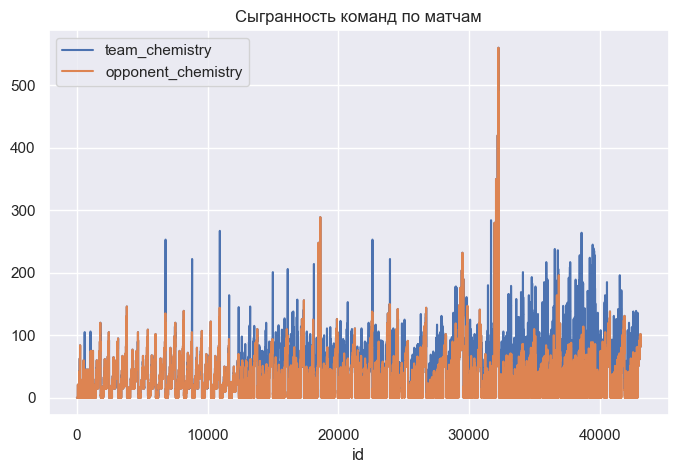

In [15]:
df.plot(x='id', y=['team_chemistry', 'opponent_chemistry'], 
       title='Сыгранность команд по матчам')

<Axes: >

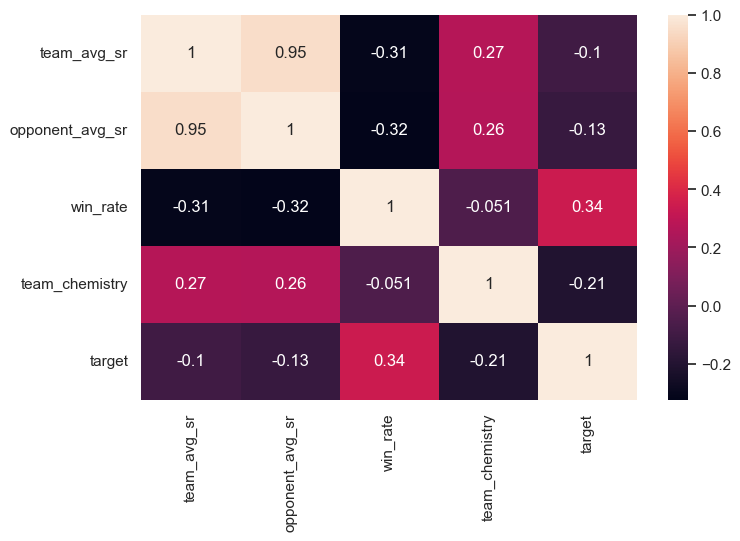

In [16]:
corr = df[['team_avg_sr', 'opponent_avg_sr', 'win_rate', 'team_chemistry', 'target']].corr()
sns.heatmap(corr, annot=True)

<Axes: xlabel='division', ylabel='win_rate'>

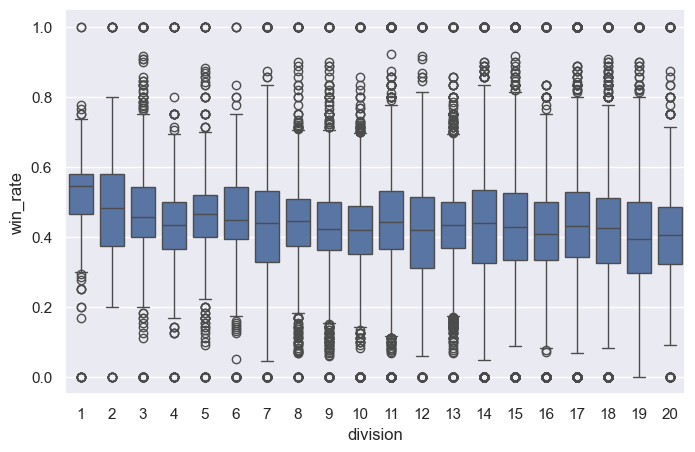

In [17]:
sns.boxplot(x='division', y='win_rate', data=df)

In [18]:
df.to_csv("../data/csv/matches.csv", index=False)